In [23]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from numpy import sqrt, exp, pi, cos, sin, log, abs
from numba_stats import norm as norm_fast
from scipy.stats import norm
from scipy.optimize import brentq
import pandas as pd
from scipy.optimize import minimize
from tqdm  import tqdm
from datetime import datetime
from numba import njit
from numba.types import List
import yfinance as yf
from nelson_siegel_svensson.calibrate import calibrate_nss_ols
import py_vollib_vectorized

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

np.seterr(all = 'ignore')
pd.options.mode.chained_assignment = None

## Comment Out if Running Locally: To get interactive plots
import plotly.io as pio
pio.renderers.default = "png"
pio.templates.default = 'plotly'
pio.templates['plotly']['layout'].update(width=1200, height=400)    ; ""
## Comment Out if Running Locally: To get interactive plots

''

# Option pricing using Fourier series - Mathematics
## Recap - From Part 2
Where $f = f_\mathbb{Q}^{log}(t, S_t, \sigma_{implied}, T, z) $ is the density of future asset prices and has characteristic function $\varphi$. Note that $z = log(S_T)$. \
So we are going to use this new tool to price a derivative $F$ whith defined payoff $F(T, S_T)$. Since $g_n$ depends only the the payoff function at $T$ we can calculate $g_n$ explicitly. Where for a put option $F(t, e^Z) = (K - e^Z)^+$::
$$\begin{align*}
&F(t, S_t, \sigma_{implied}, T) &=\;& \frac{e^{-r(T-t)}}{b-a} Re\Bigg[ g_0 + \sum_{n=1}^{N} 2\varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} g_n \Bigg]& \\
\\
&g_n &=\;& \frac{e^a - \frac{K}{h_n}\sin(h_n(a-logK)) - K\cos(h_n(a-logK))}{1+h_n^2} & ,\; for \quad n > 0\\
&g_0 &=\;& K(logK - a - 1) +e^a & ,\; for \quad n = 0\\
&h_n &=\;& \frac{n\pi}{b-a} &
\end{align*}$$
\
For a suitably large $N$ usually between $[64, 256+]$

## Heston Model - Formula
$$\begin{align*}
& dS_t      &=\;& (r-q) S_t dt + \sqrt{\nu_t}S_t dW_t^S, \\
& d\nu_t    &=\;& \kappa(\theta - \nu_t)dt + \zeta \sqrt{\nu_t}dW_t^\nu \\
& \rho dt   &=\;& dW_t^S dW_t^\nu \\
\\
& \nu_0, &=\;& \text{The initial variance} \\
& \kappa, &=\;& \text{The speed of the mean reversion} \\
& \theta, &=\;& \text{The long term mean variance} \\
& \zeta, &=\;& \text{The volatility of the volatility "vol of vol"} \\
& \rho, &=\;& \text{The correlation of the two Weiner proceses} \\
\\
&&& 2\kappa\theta > \zeta^2  \quad \text{Feller condition}
\end{align*}$$

## Heston Model - Characteristic Function
$$\begin{align*}
& \varphi(u) &=\;& \exp\left\{\mathrm{i} um + \alpha + \beta\nu_0\right\} \\
& m &=\;& log(S_0) + (r - q)*(T-t_0) \\
& \alpha &=\;& \frac{\kappa\theta}{\zeta^2}\left[(\kappa - \rho\zeta iu - D)(T-t_0) - 2log\frac{1-Ce^{-D*(T-t0)}}{1-C}\right] \\
& \beta &=\;& \frac{(\kappa - \rho\zeta iu - D)*(1-e^{-D*(T-t_0)})}{\zeta^2(1-Ce^{(-D*(T-t_0)})} \\
& C &=\;& \frac{\kappa - \rho\zeta iu - D}{\kappa - \rho\zeta iu + D} \\
& D &=\;& \sqrt{(\rho\zeta iu - \kappa)^2 + \zeta^2(iu + u^2)} \\
\end{align*}$$

## Heston Model - Integration Limits
$$\begin{align*}
& [a,b] &=\;& [c_1-12\sqrt{[c_2|]}, c_1+12\sqrt{[c_2|]}] \\
& c_1   &=\;& rT + (1-e^{-\kappa T})\frac{\theta - \nu_0}{2\kappa} - \frac{1}{2}\theta T \\
& c_2   &=\;& \frac{1}{8 \kappa^3}\left[\zeta T \kappa e^{-\kappa T}\left(\nu_0-\theta\right)(8 \kappa \rho-4 \zeta)\right. \\
&&& +\kappa \rho \zeta\left(1-e^{-\kappa T}\right)\left(16 \theta-8 \nu_0\right) \\
&&& +2 \theta \kappa T\left(-4 \kappa \rho \zeta+\zeta^2+4 \kappa^2\right) \\
&&& +\zeta^2\left(\left(\theta-2 \nu_0\right) e^{-2 \kappa T}+\theta\left(6 e^{-\kappa T}-7\right)+2 \nu_0\right) \\
&&& \left.+8 \kappa^2\left(\nu_0-\theta\right)\left(1-e^{-\kappa T}\right)\right]
\end{align*}$$

## GBM Cumulants 
$$\begin{align*}
& c1  &=\;& log(S_0) + rT \\
& c_2 &=\;& \sigma^2T \\
& [a,b] &=\;& [c_1 - 12\sqrt{|c_2|}, c_1 + 12\sqrt{|c_2|}] \\
\end{align*}$$

## Heston Model Cumulants

$$\begin{align*}
& c_1   &=\;& log(S_0) + rT + (1-e^{-\kappa T})\frac{\theta - \nu_0}{2\kappa} - \frac{1}{2}\theta T \\
& c_2   &=\;& \frac{\theta}{8\kappa^3}\big[-\zeta^2e^{-2\kappa T} + 4\zeta e^{-\kappa T}(\zeta-2\kappa \rho) \\ 
&&&            + 2\kappa T (4\kappa^2 + \zeta^2 - 4\kappa\zeta\rho) + \zeta(8\kappa\rho - 3\zeta \big] \\
& [a,b] &=\;& [c_1 - 24\sqrt{|c_2|}, c_1 + 24\sqrt{|c_2|}] \\
\end{align*}$$

In [24]:
S0      = 100.      # initial asset price
K       = 50.       # strike
r       = 0.03      # risk free rate
T       = 1/365     # time to maturity

v0=0.4173 ; kappa=0.4352 ; theta=0.2982 ; zeta=1.3856 ; rho=-0.0304

In [25]:
@njit
def Fourier_Heston_Put(S0, K, T, r, 
                    # Heston Model Paramters
                    kappa, # Speed of the mean reversion 
                    theta, # Long term mean
                    rho,   # correlation between 2 random variables
                    zeta,  # Volatility of volatility
                    v0,    # Initial volatility 
                    opt_type,
                    N = 10_012,
                    z = 24
                    ):

    def heston_char(u): 
        t0 = 0.0 ;  q = 0.0
        m = log(S0) + (r - q)*(T-t0)
        D = sqrt((rho*zeta*1j*u - kappa)**2 + zeta**2*(1j*u + u**2))
        C = (kappa - rho*zeta*1j*u - D) / (kappa - rho*zeta*1j*u + D)
        beta = ((kappa - rho*zeta*1j*u - D)*(1-exp(-D*(T-t0)))) / (zeta**2*(1-C*exp(-D*(T-t0))))
        alpha = ((kappa*theta)/(zeta**2))*((kappa - rho*zeta*1j*u - D)*(T-t0) - 2*log((1-C*exp(-D*(T-t0))/(1-C))))
        return exp(1j*u*m + alpha + beta*v0)
    
    c1 = log(S0) + r*T - .5*theta*T
    c2 = theta/(8*kappa**3)*(-zeta**2*exp(-2*kappa*T) + 4*zeta*exp(-kappa*T)*(zeta-2*kappa*rho) 
            + 2*kappa*T*(4*kappa**2 + zeta**2 - 4*kappa*zeta*rho) + zeta*(8*kappa*rho - 3*zeta))
    a = c1 - z*sqrt(abs(c2))
    b = c1 + z*sqrt(abs(c2))
    
    h       = lambda n : (n*pi) / (b-a) 
    g_n     = lambda n : (exp(a) - (K/h(n))*sin(h(n)*(a - log(K))) - K*cos(h(n)*(a - log(K)))) / (1 + h(n)**2)
    g0      = K*(log(K) - a - 1) + exp(a)
    
    F = g0 
    for n in range(1, N+1):
        h_n = h(n)
        F += 2*heston_char(h_n) * exp(-1j*a*h_n) * g_n(n)

    F = exp(-r*T)/(b-a) * np.real(F)
    F = F if opt_type == 'p' else F + S0 - K*exp(-r*T)
    return F if F > 0 else 0

N = 1_012
print(f'Speed Analysis of Fourier_Heston_Put: Per Option. N = {N}')
%timeit Fourier_Heston_Put(S0,K, T, r, kappa, theta, rho, zeta, v0, 'p', N = N, z = 24)

Speed Analysis of Fourier_Heston_Put: Per Option. N = 1012
153 µs ± 5.43 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# How To Calculate IV
Since there is no analytical solution to get the IV for the Black-Scholes model we need to numerically approxiamte it.  
Library: py_vollib_vectorized

In [26]:
price = 0.10 ; S = 95 ; K = 100 ; t = .2 ; r = .2 ; flag = 'c'

# This code uses the py_vollib_vectorized library to calculate the implied volatilities of each of the options in the data set.
# The library is vectorized, so the function is applied to each of the options in the data set, and the result is a vector of implied volatilities.
# The function is then timed to see how long it takes to run.

def get_implied_volatility(price, S, K, t, r, flag):
    return py_vollib_vectorized.vectorized_implied_volatility(
        price, S, K, t, r, flag, q=0.0, on_error='ignore', model='black_scholes_merton',return_as='numpy') 

print('Speed Analysis of the implied volatility Function: Per Option')
%timeit get_implied_volatility(price, S, K, t, r, flag)

Speed Analysis of the implied volatility Function: Per Option
48.9 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# US Tresury Rates - RFR
Site: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202306

## Nelson Siegel Svensson - Formula for Interest Rates
$$
r(T)=\beta_0+\beta_1\left[\frac{1-\exp \left(-T / \lambda_0\right)}{T / \lambda_0}\right]+\beta_2\left[\frac{1-\exp \left(-T / \lambda_0\right)}{T / \lambda_0}-\exp \left(-T / \lambda_0\right)\right]+\beta_3\left[\frac{1-\exp \left(-T / \lambda_1\right)}{T / \lambda_1}-\exp \left(-T / \lambda_1\right)\right]
$$

### Nelson Siegel Svensson - Python Package
Site: https://nelson-siegel-svensson.readthedocs.io/en/latest/usage.html

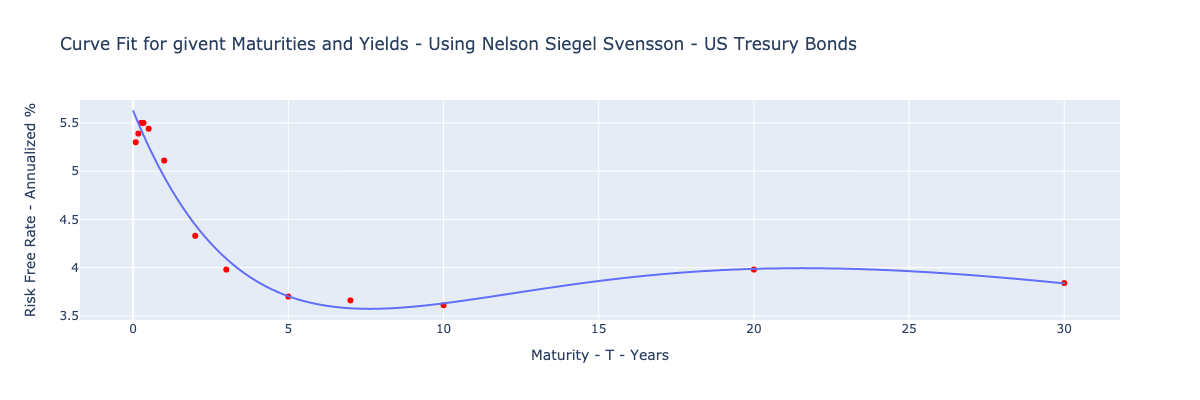

NelsonSiegelSvenssonCurve(beta0=1.193267885148061, beta1=4.432851072732896, beta2=-403.39699798471366, beta3=405.07377170641735, tau1=6.831345205589173, tau2=6.970627082129859)

In [27]:
# Collected at : 06/01/2023
yield_maturities = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yields           = np.array([5.30,5.39,5.50,5.50,5.44,5.11,4.33,3.98,3.70,3.66,3.61,3.98,3.84])

#NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities,yields) 
df_IR = pd.DataFrame(np.arange(1, 30*365)/365, columns=['Interest Rate'], index=np.arange(1, 30*365)/365,).apply(curve_fit)
df_IR = df_IR.reset_index().rename(columns={'index':'Maturity'})

fig1 = px.line(df_IR, x="Maturity", y="Interest Rate")
fig2 = px.scatter(pd.DataFrame(list(zip(yield_maturities, yields)), columns=['Maturity', 'Interest Rate']), x="Maturity", y="Interest Rate")
fig2.update_traces(marker=dict(color='red'))

fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.update_layout(
    title=dict(text="Curve Fit for givent Maturities and Yields - Using Nelson Siegel Svensson - US Tresury Bonds"),
    xaxis_title="Maturity - T - Years" , yaxis_title="Risk Free Rate - Annualized % " , 
)
fig3.show()
curve_fit

# Collection of Option Chain over all available maturities

S0=4450.31982421875


/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_14924/1467481439.py:34: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.



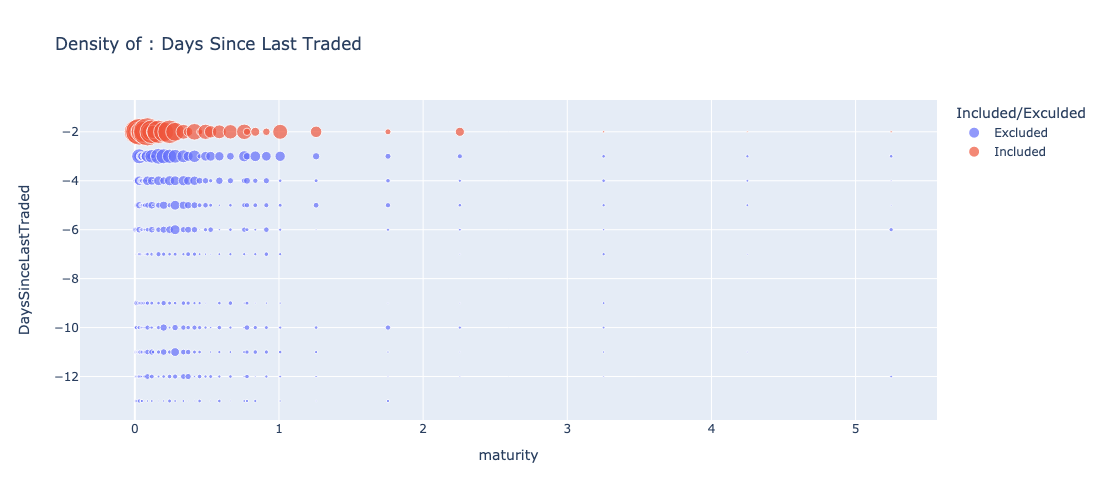

,index,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,DaysSinceLastTraded,Weight,price,maturity,S,rate
count,4466.000000,4466.000000,4466.000000,4466.000000,4466.000000,4466.000000,4466.000000,4466.000000,4466.000000,4466.000000,4466.000000,4466.0,4466.000000,4466.000000,4466.000000,4466.000000,4466.000000
mean,94.043663,4257.960143,64.770815,60.006046,61.546440,-1.074897,8.186236,250.549037,1768.448500,0.176586,0.218316,-2.0,1.000000,60.776243,0.213840,4450.319824,0.054740
std,71.024410,650.748740,194.771085,188.700523,192.249658,19.429701,58.599849,783.727829,5288.851146,0.143932,0.413149,0.0,3.034240,190.465243,0.350435,0.000000,0.002162
min,0.000000,200.000000,0.030000,0.000000,0.000000,-80.139984,-98.809520,1.000000,0.000000,0.000010,0.000000,-2.0,0.000004,0.000000,0.002740,4450.319824,0.036772
25%,39.000000,4110.000000,3.285000,2.612500,2.950000,-7.557500,-27.387147,8.000000,83.000000,0.110828,0.000000,-2.0,0.028133,2.775000,0.030137,4450.319824,0.054414
50%,74.000000,4400.000000,19.725000,18.400000,19.100000,0.100000,3.583944,37.500000,289.000000,0.137168,0.000000,-2.0,0.097031,18.800000,0.087671,4450.319824,0.055574
75%,137.000000,4545.000000,65.437500,62.175000,63.800000,6.097500,33.207919,156.750000,1094.750000,0.192309,0.000000,-2.0,0.528281,63.087500,0.241096,4450.319824,0.056023
max,322.000000,8800.000000,4259.200000,4210.700000,4264.000000,269.100100,447.234070,16594.000000,145950.000000,3.311037,1.000000,-2.0,19.018114,4237.350000,5.246575,4450.319824,0.056239


In [28]:
SPX = yf.Ticker("^SPX")

# Step 1: get last clossing price
S0 = SPX.history(perdiod='3mo')['Close'][-1] ; print(f'S0={S0}')

# Step 2: get Expiration Dates
expiration_dates = SPX.options

# Step 3: get option chain for each expiration date
df = []
for expiration_date in tqdm(expiration_dates, desc='Collecting Option Data'):
    # Collect all Calls
    _df = SPX.option_chain(expiration_date).calls
    _df['DaysSinceLastTraded'] = (pd.to_datetime(_df['lastTradeDate']).dt.tz_localize(None) - pd.to_datetime(datetime.now())).dt.days
    _df = _df[_df['DaysSinceLastTraded'] > -14]
    _df['Weight'] = 1 / (_df['bid'] - _df['ask'])**2
    _df['price']  = (_df['bid'] + _df['ask'])/2
    _df['maturity'] = (pd.to_datetime(expiration_date) - pd.to_datetime(datetime.now())).days / 365
    _df['Type']     = 'c'
    _df['S']        = S0
    df.append(_df)

    # Collect all Puts
    _df = SPX.option_chain(expiration_date).puts
    _df['DaysSinceLastTraded'] = (pd.to_datetime(_df['lastTradeDate']).dt.tz_localize(None) - pd.to_datetime(datetime.now())).dt.days
    _df = _df[_df['DaysSinceLastTraded'] > -14]
    _df['Weight'] = 1 / (_df['bid'] - _df['ask'])**2
    _df['price']  = (_df['bid'] + _df['ask'])/2
    _df['maturity'] = (pd.to_datetime(expiration_date) - pd.to_datetime(datetime.now())).days / 365
    _df['Type']     = 'p'
    _df['S']        = S0
    df.append(_df)

df = pd.concat(df)
df = df[df['maturity'] > 0]

# Days since Last Traded. If yesterday's results are uploaded to yfinance. Then the max should be -1.
# -> change iloc -1 to -3 depending on how many days you want to take
Lookback_limit = df['DaysSinceLastTraded'].sort_values().unique()[-1]

# Plot Density of Options for each maturity
DaysSinceLastTraded_df = df.groupby(['DaysSinceLastTraded', 'maturity'])['price'].count().reset_index()
DaysSinceLastTraded_df['Included/Exculded'] = ['Included' if x >= Lookback_limit else 'Excluded' for x in DaysSinceLastTraded_df['DaysSinceLastTraded'].values]
DaysSinceLastTraded_df['Number of Options']  = DaysSinceLastTraded_df['price'].values

fig = px.scatter(DaysSinceLastTraded_df, x='maturity', y='DaysSinceLastTraded', color='Included/Exculded', size='Number of Options',
    width=1100, height=500, title='Density of : Days Since Last Traded')
fig.show()


# Limit the space to calibrate the model according to requirements
volSurfaceLong = (
    df[
        (df['maturity'] > 0)
        & (df['DaysSinceLastTraded'] >= Lookback_limit)
    ]
)
del _df, df, DaysSinceLastTraded_df

volSurfaceLong['rate'] = volSurfaceLong['maturity'].apply(curve_fit) / 100
volSurfaceLong         = volSurfaceLong.reset_index()

# Data Cleaning: Sets the inf weighted values to the maximum weight 
volSurfaceLong.loc[ volSurfaceLong['Weight'] == np.inf , 'Weight'] = volSurfaceLong[ volSurfaceLong['Weight'] != np.inf ]['Weight'].max()
volSurfaceLong['Weight'] = volSurfaceLong['Weight'] / volSurfaceLong['Weight'].mean()

volSurface = volSurfaceLong#.sample(n=250)
volSurface.describe()

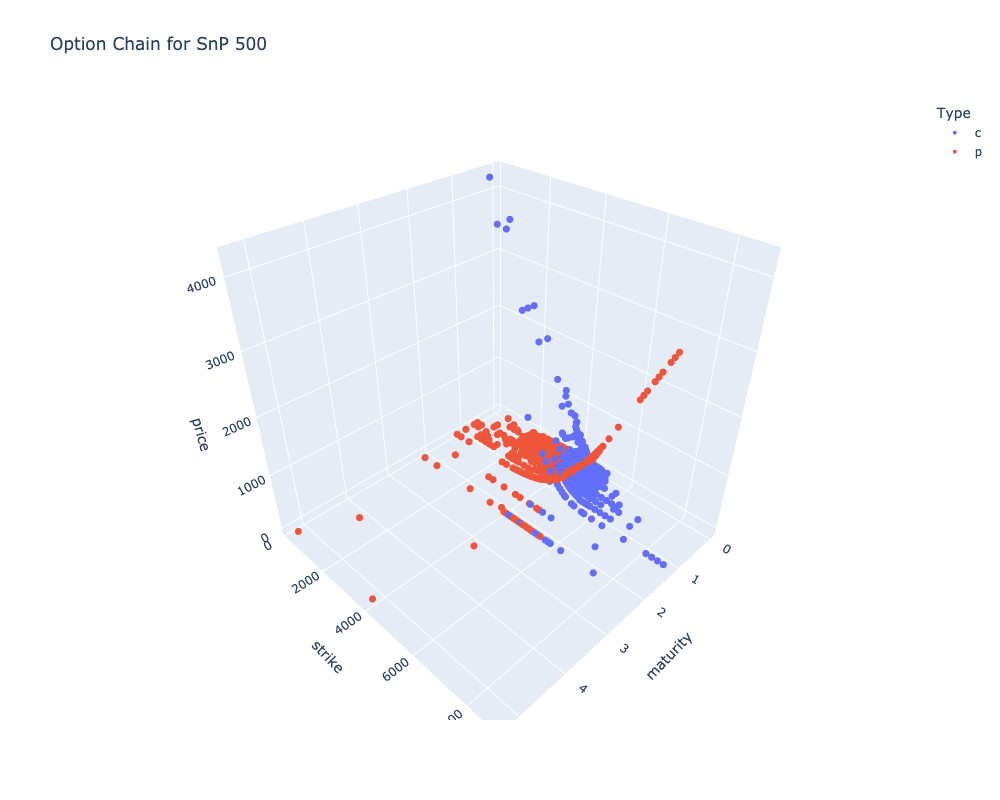

In [29]:
# This code is used to generate a 3D scatter plot of the option chain for the SnP 500. 
# This plot is useful to visualize the relationship between the strike price, the maturity, and the price of an option. 
# This plot can be used to determine the optimal strike price and maturity for an option.

fig = px.scatter_3d(volSurface, x='maturity', y='strike', z='price', width=1000, height=800, size_max=.5, color='Type', title='Option Chain for SnP 500')
fig.update_traces(marker={'size': 4})
fig.show()

Options Droped where IV == 0: 154 , aka Options which the middpoint cannot be priced


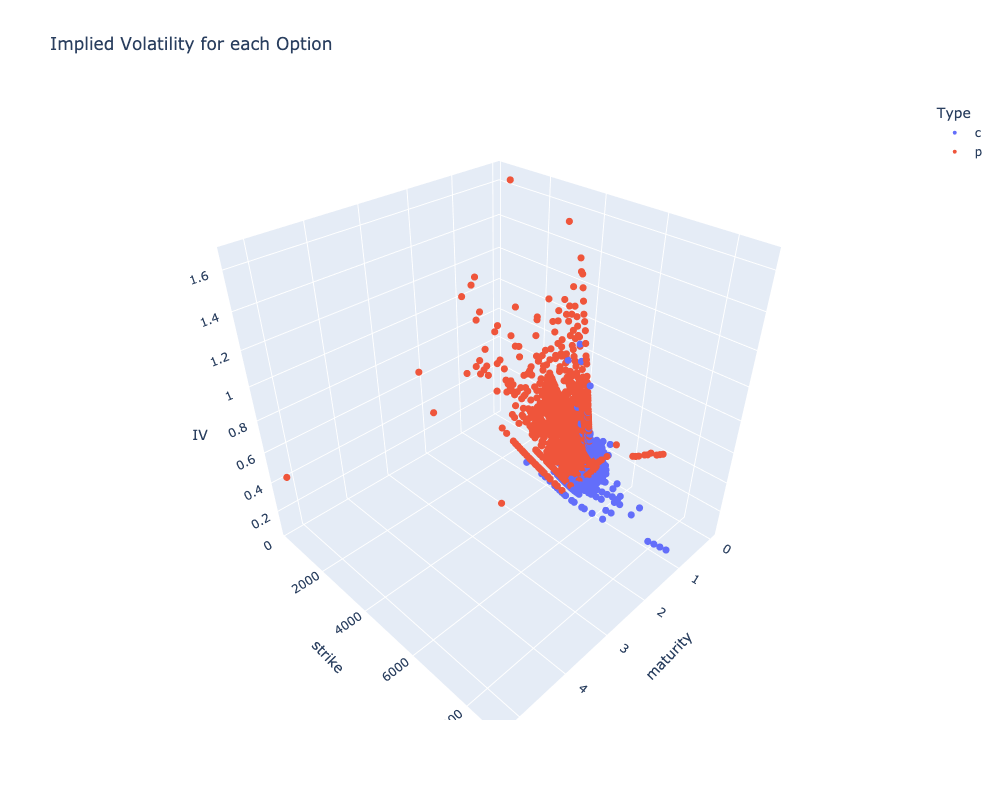

In [30]:
# The code above is simply a visualization of the implied volatility for each of the options in the dataset. 
# Each point represents an option, and the colors represent the type of option. 
# From this graph, we can see how the implied volatility is related to the strike price and the maturity. 
# We can see that the implied volatility is higher for options that are further out of the money. 
# We can also see that the implied volatility is higher for options that are further out in time.

_K          = volSurface['strike'].to_numpy()
_P          = volSurface['price'].to_numpy()
_T          = volSurface['maturity'].to_numpy()
_r          = volSurface['rate'].to_numpy()
_S          = volSurface['S'].to_numpy()
opt_types   = volSurface['Type'].to_numpy(dtype=str)

volSurface['IV'] = get_implied_volatility(price=_P, S=_S, K=_K, t=_T, r=_r, flag=opt_types)
volSurface = volSurface[~volSurface.IV.isna()]
print(f'Options Droped where IV == 0: {(~(volSurface.IV > 0)).sum()} , aka Options which the middpoint cannot be priced')
volSurface = volSurface[volSurface.IV > 0]
volSurface = volSurface[(volSurface['IV'] != np.inf) & (volSurface['IV'] != np.nan)]

fig = px.scatter_3d(volSurface, x='maturity', y='strike', z='IV', width=1000, height=800, size_max=.5, color='Type', 
    title='Implied Volatility for each Option', hover_data=['price', 'strike', "rate"])
fig.update_traces(marker={'size': 4})
fig.show()

In [31]:
def get_error_Heston(volSurface, v0, kappa, theta, zeta, rho):
    """Calculates the error between the Heston model and the market prices.
    Arguments:
        volSurface: DataFrame with the market prices.
        v0: Initial variance.
        kappa: Mean reversion speed.
        theta: Long-run variance.
        zeta: Volatility of volatility.
        rho: Correlation between the variance and the asset.
    """
    error = 0
    for _, row in volSurface.iterrows():
        P = row['price']
        HP = Fourier_Heston_Put(S0=row['S'], K=row['strike'], v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, T=row['maturity'], r=row['rate'], N=2048)
        error += (P - HP)**2

    return error / volSurface.shape[0]

def get_resutls_array_Heston(volSurface, v0, kappa, theta, zeta, rho, N=10_000, z=64):
    # Initialize the results array
    results = -np.ones(volSurface.shape[0])
    # reset the index of the options dataframe
    volSurface.index = np.arange(0, volSurface.shape[0])
    # loop through the rows of the options dataframe and run the Fourier_Heston_Put function
    for idx, row in volSurface.iterrows():
        results[idx] = Fourier_Heston_Put(S0=int(row['S']), K=int(row['strike']), v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, T=row['maturity'], r=row['rate'], N=N, opt_type=row['Type'],z=z)
    return results

def get_resutls_df_Heston(volSurface, v0, kappa, theta, zeta, rho, N=2048, z=100):
    observed = volSurface.copy(deep=True)
    heston = volSurface.copy(deep=True)
    observed['source'] = 'Observed'
    heston['source'] = 'Heston Model'

    heston_prices = [] 
    implied_volatilities = []
    for _, row in volSurface.iterrows():
        heston_price = Fourier_Heston_Put(S0=row['S'], K=row['strike'], v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, T=row['maturity'], r=row['rate'], N=N, opt_type=row['Type'], z=z)
        heston_prices.append(heston_price)
        # np.array(... , ndmin=1) So the type of the input is compatible with what numba expects
        maturity  = np.array(row['maturity'],ndmin=1)
        observed_price  = np.array(heston_price,ndmin=1)
        S0 = np.array(row['S'],ndmin=1)
        K  = np.array(row['strike'],ndmin=1)
        r  = np.array(row['rate'],ndmin=1)
        option_type = np.array(row['Type'],ndmin=1)
        implied_volatility = get_implied_volatility(price=observed_price, S=S0, K=K, t=maturity, r=r, flag=option_type)
        implied_volatilities.append(implied_volatility[0])

    heston['price'] = heston_prices
    heston['IV']    = implied_volatilities

    return pd.concat([observed, heston])

def get_error_df_Heston(volSurface, v0, kappa, theta, zeta, rho, diff='Price', error='Error', weighted=True, N=10_000, z=64):
    if   error == 'Error':          _name = f'Weighted Error {diff}'             if weighted else f'Error {diff}'
    elif error == 'Perc Error':     _name = f'Weighted Persentage Error {diff}'  if weighted else f'Persentage Error {diff}'
    elif error == 'Squared Error':  _name = f'Weighted Squared Error {diff}'     if weighted else f'Squared Error {diff}'
    else: raise Exception("Error: variable 'error' is not defined correctly")
    
    results_df = {'strike':[], 'maturity':[], _name:[], 'Opt. Type':[], 'Weight':[]}

    for _, row in volSurface.copy(deep=True).iterrows():
        _P = Fourier_Heston_Put(S0=row['S'], K=row['strike'], v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, T=row['maturity'], r=row['rate'], N=N, z=z, opt_type=row['Type'])
        # np.array(... , ndmin=1) So the type of the input is compatible with what numba expects
        _T  = np.array(row['maturity'],ndmin=1)
        _C  = np.array(_P,ndmin=1)
        _P  = np.array(row['price'],ndmin=1)
        _S0 = np.array(row['S'],ndmin=1)
        _K  = np.array(row['strike'],ndmin=1)
        _r  = np.array(row['rate'],ndmin=1)
        _OT = np.array(row['Type'],ndmin=1)

        _IV  = get_implied_volatility(price=_C, S=_S0, K=_K, t=_T, r=_r, flag=_OT)
        _IV2 = get_implied_volatility(price=row['price'], S=_S0, K=_K, t=_T, r=_r, flag=_OT)

        if error    == 'Error':
            if diff == 'IV':  _error  = (_IV - _IV2) *                (row['Weight'] if weighted else 1)
            else           :  _error  = (_C - _P) *                   (row['Weight'] if weighted else 1)
        elif error  == 'Perc Error':
            if diff == 'IV':  _error  = ((_IV - _IV2)/_IV2) * 100 *   (row['Weight'] if weighted else 1)
            else           :  _error  = ((_C - _P)/_P) * 100 *        (row['Weight'] if weighted else 1)
        elif error  == 'Squared Error':
            if diff == 'IV':  _error  = (_IV - _IV2)**2 *             (row['Weight'] if weighted else 1)
            else           :  _error  = (_C - _P)**2 *                (row['Weight'] if weighted else 1)

        results_df[_name].append(_error[0])
        results_df['maturity'].append(_T[0])
        results_df['strike'].append(_K[0])
        results_df['Opt. Type'].append(_OT[0])
        results_df['Weight'].append(row['Weight']*10)

    return pd.DataFrame(results_df)

# Calibration of Heston parameters

The advantage of minimizing squared implied volatility differences instead of squared price differences is that
the former gives more comparable weights to in- and out-of-the money options.
$$\begin{align*}
& \min _{\kappa, \theta, \zeta, \rho, v_t} && \sum_{T \in \mathcal{T}, K \in \mathcal{K}}w\left(\sigma_{\text {imp }}(T, K)-F_{B S}^{-1}\left(F\left(t, S_t, v_t\right)\right)\right)^2 \\
& w &=\;& \frac{1}{spread^2} \\
& spread &=\;& ask - bid
\end{align*}$$

In [32]:
# Extract data from volSurface DataFrame
_K      = volSurface['strike'].to_numpy()
_C      = volSurface['price'].to_numpy()
_type   = volSurface['Type'].to_numpy(dtype=str)
_T      = volSurface['maturity'].to_numpy()
_r      = volSurface['rate'].to_numpy()
_S      = np.full_like(_K, S0)
_IV     = volSurface['IV'].to_numpy()
_Weight = volSurface['Weight'].to_numpy()

# Initial parameters and bounds for optimization
params = {
    "v0": {"x0": 0.002874, "lbub": [1e-3, 1.2]},
    "kappa": {"x0": 1.6891, "lbub": [1e-3, 10]},
    "theta": {"x0": 0.0190, "lbub": [1e-3, 1.2]},
    "zeta": {"x0": 3.7472, "lbub": [1e-2, 4]},
    "rho": {"x0": -0.2731, "lbub": [-1, 1]}
}
x0 = [param["x0"] for _, param in params.items()]
bnds = [param["lbub"] for _, param in params.items()]

# Objective function: Squared Error
def SqErr(x):
    v0, kappa, theta, zeta, rho = x
    
    # Calculate prices using Heston Model
    Price_Heston = get_resutls_array_Heston(
        volSurface, v0, kappa, theta, zeta, rho, N=1_012, z=24
    )
    
    # Calculate implied volatilities
    IV_Heston = get_implied_volatility(
        price=Price_Heston, S=_S, K=_K, t=_T, r=_r, flag=_type
    )
    
    # Handle undefined IV calculations
    diff = IV_Heston - _IV
    idx = np.isnan(diff) | np.isinf(diff)
    diff[idx] = 0 - _IV[idx]
    IV_Heston[idx] = 0
    
    # Calculate RMSE
    rmse = sqrt(np.mean((diff * 100) ** 2 * _Weight))
    
    # Debugging info
    zeros = int(np.where(IV_Heston == 0, 1, 0).sum())
    wmae  = np.mean(np.abs(diff * 100) * _Weight)
    print_debug_info(v0, kappa, theta, zeta, rho, wmae, idx, zeros, rmse)
    
    return rmse

# Debugging info printer
def print_debug_info(v0, kappa, theta, zeta, rho, wmae, idx, zeros, rmse):
    print(
        f">>v0={v0:.4f}; kappa={kappa:.4f}; theta={theta:.4f}; "
        f"zeta={zeta:.4f}; rho={rho:7.4f} | WMAE(IV): {wmae:.5e} | "
        f"Nulls: {idx.sum()}/{idx.shape[0]} | Zeros: {zeros}/{idx.shape[0]} | "
        f"WRMSE(IV): {rmse:.5e}"
    )

# Run optimization
result = minimize(
    SqErr, x0, tol=1e-5, method='SLSQP',
    options={'maxiter': 80, 'ftol': 1e-5, 'disp': True},
    bounds=bnds, jac='3-point'
)

# Extract optimized parameters
v0, kappa, theta, zeta, rho = result.x


>>v0=0.0029; kappa=1.6891; theta=0.0190; zeta=3.7472; rho=-0.2731 | WMAE(IV): 3.25933e+00 | Nulls: 0/4312 | Zeros: 21/4312 | WRMSE(IV): 6.70915e+00
>>v0=0.0029; kappa=1.6891; theta=0.0190; zeta=3.7472; rho=-0.2731 | WMAE(IV): 3.25951e+00 | Nulls: 0/4312 | Zeros: 21/4312 | WRMSE(IV): 6.70924e+00
>>v0=0.0029; kappa=1.6891; theta=0.0190; zeta=3.7472; rho=-0.2731 | WMAE(IV): 3.25914e+00 | Nulls: 0/4312 | Zeros: 21/4312 | WRMSE(IV): 6.70905e+00
>>v0=0.0029; kappa=1.6891; theta=0.0190; zeta=3.7472; rho=-0.2731 | WMAE(IV): 3.25933e+00 | Nulls: 0/4312 | Zeros: 21/4312 | WRMSE(IV): 6.70915e+00
>>v0=0.0029; kappa=1.6891; theta=0.0190; zeta=3.7472; rho=-0.2731 | WMAE(IV): 3.25932e+00 | Nulls: 0/4312 | Zeros: 21/4312 | WRMSE(IV): 6.70915e+00
>>v0=0.0029; kappa=1.6891; theta=0.0190; zeta=3.7472; rho=-0.2731 | WMAE(IV): 3.25993e+00 | Nulls: 0/4312 | Zeros: 21/4312 | WRMSE(IV): 6.70999e+00
>>v0=0.0029; kappa=1.6891; theta=0.0190; zeta=3.7472; rho=-0.2731 | WMAE(IV): 3.25861e+00 | Nulls: 0/4312 | Zero

/Users/alexanderithakis/miniforge3/envs/QF/lib/python3.10/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



>>v0=0.0826; kappa=0.0010; theta=0.0367; zeta=4.0000; rho=-1.0000 | WMAE(IV): 1.29618e+01 | Nulls: 0/4312 | Zeros: 667/4312 | WRMSE(IV): 2.39634e+01
>>v0=0.0092; kappa=1.0039; theta=0.0399; zeta=4.0000; rho=-0.3758 | WMAE(IV): 3.16768e+00 | Nulls: 0/4312 | Zeros: 24/4312 | WRMSE(IV): 7.01504e+00
>>v0=0.0018; kappa=1.1042; theta=0.0402; zeta=4.0000; rho=-0.3133 | WMAE(IV): 2.23514e+00 | Nulls: 0/4312 | Zeros: 6/4312 | WRMSE(IV): 4.69458e+00
>>v0=0.0018; kappa=1.1042; theta=0.0402; zeta=4.0000; rho=-0.3133 | WMAE(IV): 2.23514e+00 | Nulls: 0/4312 | Zeros: 6/4312 | WRMSE(IV): 4.69461e+00
>>v0=0.0018; kappa=1.1042; theta=0.0402; zeta=4.0000; rho=-0.3133 | WMAE(IV): 2.23514e+00 | Nulls: 0/4312 | Zeros: 6/4312 | WRMSE(IV): 4.69455e+00
>>v0=0.0018; kappa=1.1042; theta=0.0402; zeta=4.0000; rho=-0.3133 | WMAE(IV): 2.23513e+00 | Nulls: 0/4312 | Zeros: 6/4312 | WRMSE(IV): 4.69458e+00
>>v0=0.0018; kappa=1.1042; theta=0.0402; zeta=4.0000; rho=-0.3133 | WMAE(IV): 2.23514e+00 | Nulls: 0/4312 | Zeros: 

/Users/alexanderithakis/miniforge3/envs/QF/lib/python3.10/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



>>v0=0.0866; kappa=0.0010; theta=0.0364; zeta=4.0000; rho=-1.0000 | WMAE(IV): 1.28296e+01 | Nulls: 0/4312 | Zeros: 642/4312 | WRMSE(IV): 2.40028e+01
>>v0=0.0103; kappa=0.9939; theta=0.0398; zeta=4.0000; rho=-0.3820 | WMAE(IV): 3.28881e+00 | Nulls: 0/4312 | Zeros: 26/4312 | WRMSE(IV): 7.17529e+00
>>v0=0.0027; kappa=1.0932; theta=0.0402; zeta=4.0000; rho=-0.3202 | WMAE(IV): 2.18438e+00 | Nulls: 0/4312 | Zeros: 6/4312 | WRMSE(IV): 4.67230e+00
>>v0=0.0027; kappa=1.0932; theta=0.0402; zeta=4.0000; rho=-0.3202 | WMAE(IV): 2.18437e+00 | Nulls: 0/4312 | Zeros: 6/4312 | WRMSE(IV): 4.67231e+00
>>v0=0.0027; kappa=1.0932; theta=0.0402; zeta=4.0000; rho=-0.3202 | WMAE(IV): 2.18440e+00 | Nulls: 0/4312 | Zeros: 6/4312 | WRMSE(IV): 4.67228e+00
>>v0=0.0027; kappa=1.0932; theta=0.0402; zeta=4.0000; rho=-0.3202 | WMAE(IV): 2.18438e+00 | Nulls: 0/4312 | Zeros: 6/4312 | WRMSE(IV): 4.67230e+00
>>v0=0.0027; kappa=1.0932; theta=0.0402; zeta=4.0000; rho=-0.3202 | WMAE(IV): 2.18439e+00 | Nulls: 0/4312 | Zeros: 

/Users/alexanderithakis/miniforge3/envs/QF/lib/python3.10/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



>>v0=0.0096; kappa=0.0010; theta=0.0411; zeta=4.0000; rho=-0.2755 | WMAE(IV): 5.52279e+00 | Nulls: 0/4312 | Zeros: 15/4312 | WRMSE(IV): 1.06992e+01
>>v0=0.0032; kappa=0.9672; theta=0.0403; zeta=4.0000; rho=-0.3210 | WMAE(IV): 2.10510e+00 | Nulls: 0/4312 | Zeros: 9/4312 | WRMSE(IV): 4.64873e+00
>>v0=0.0032; kappa=0.9672; theta=0.0403; zeta=4.0000; rho=-0.3210 | WMAE(IV): 2.10511e+00 | Nulls: 0/4312 | Zeros: 9/4312 | WRMSE(IV): 4.64875e+00
>>v0=0.0032; kappa=0.9672; theta=0.0403; zeta=4.0000; rho=-0.3210 | WMAE(IV): 2.10509e+00 | Nulls: 0/4312 | Zeros: 9/4312 | WRMSE(IV): 4.64870e+00
>>v0=0.0032; kappa=0.9672; theta=0.0403; zeta=4.0000; rho=-0.3210 | WMAE(IV): 2.10510e+00 | Nulls: 0/4312 | Zeros: 9/4312 | WRMSE(IV): 4.64873e+00
>>v0=0.0032; kappa=0.9672; theta=0.0403; zeta=4.0000; rho=-0.3210 | WMAE(IV): 2.10510e+00 | Nulls: 0/4312 | Zeros: 9/4312 | WRMSE(IV): 4.64873e+00
>>v0=0.0032; kappa=0.9672; theta=0.0403; zeta=4.0000; rho=-0.3210 | WMAE(IV): 2.10493e+00 | Nulls: 0/4312 | Zeros: 9/

In [33]:
# Collect and Analyze Fit
# v0=0.02287 ; kappa=0.1429 ; theta=0.0206 ; zeta=1.1834 ; rho=-0.3030 
# v0=0.02347 ; kappa=0.5200 ; theta=0.0057 ; zeta=1.2179 ; rho=-0.3162 
resulds_df = get_resutls_df_Heston(volSurface, v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, N=1_012, z=24)

heston_IV = resulds_df.query("source == 'Heston Model'")['IV'] * 100
origin_IV = resulds_df.query("source == 'Observed'")['IV'] * 100
heston_C  = resulds_df.query("source == 'Heston Model'")['price']
origin_C  = resulds_df.query("source == 'Observed'")['price']

weights   = resulds_df.query("source == 'Observed'")['Weight']

# -------------------------------- Error for Prices --------------------------------
mae_price       = np.abs(heston_C - origin_C).mean()
w_mae_price     = np.abs((heston_C - origin_C)*weights).mean()

mape_price      = np.abs(((heston_C - origin_C)/origin_C)*100).mean()
w_mape_price    = np.abs(((heston_C - origin_C)/origin_C)*100*weights).mean()
max_ape_price   = np.abs(((heston_C - origin_C)/origin_C)*100).max()

rmse_price      = np.sqrt(np.square(heston_C - origin_C).mean())
w_rmse_price    = np.sqrt(np.mean((heston_C - origin_C)**2 * weights))

# -------------------------------- Error for IV --------------------------------
mae_iv          = np.abs(heston_IV - origin_IV).mean()
w_mae_iv        = np.abs((heston_IV - origin_IV)*weights).mean()

mape_iv         = np.abs(((heston_IV - origin_IV)/origin_IV)*100).mean()
w_mape_iv       = np.abs(((heston_IV - origin_IV)/origin_IV)*100*weights).mean()
max_ape_iv      = np.abs(((heston_IV - origin_IV)/origin_IV)*100).max()

rmse_iv         = np.sqrt(np.square(heston_IV - origin_IV).mean())
w_rmse_iv       = np.sqrt(np.mean((heston_IV - origin_IV)**2 * weights))

print(f"""
Results:
v0={v0:.4} ; kappa={kappa:.4f} ; theta={theta:.4f} ; zeta={zeta:.4f} ; rho={rho:.4f} 
>>Zeros : {int(np.where(heston_IV==0, 1,0).sum())}

# -------------------------------- Error for Prices --------------------------------
MAE of Price     : {mae_price     : .4f}
WMAE of Price    : {w_mae_price   : .4f}

MAPE of Price    : {mape_price    : .3f} %
WMAPE of Price   : {w_mape_price  : .3f} %
Max APE of Price : {max_ape_price : .3f} %

RMSE of Price    : {rmse_price    : .4f}
WRMSE of Price   : {w_rmse_price  : .4f}

# -------------------------------- Error for IV --------------------------------

MAE of IV     : {mae_iv     : .4f}
WMAE of IV    : {w_mae_iv   : .4f}

MAPE of IV    : {mape_iv    : .3f} %
WMAPE of IV   : {w_mape_iv  : .3f} %
Max APE of IV : {max_ape_iv : .3f} %

RMSE of IV    : {rmse_iv    : .4f}
-> WRMSE of IV: {w_rmse_iv  : .4f}
""")
del heston_IV, origin_IV, weights, mae_iv , w_mae_iv, mape_iv, w_mape_iv


Results:
v0=0.01052 ; kappa=0.2729 ; theta=0.0436 ; zeta=2.2777 ; rho=-0.3381 
>>Zeros : 9

# -------------------------------- Error for Prices --------------------------------
MAE of Price     :  18.5181
WMAE of Price    :  0.8628

MAPE of Price    :  71.375 %
WMAPE of Price   :  102.007 %
Max APE of Price :  4524.788 %

RMSE of Price    :  36.4633
WRMSE of Price   :  4.8365

# -------------------------------- Error for IV --------------------------------

MAE of IV     :  3.5382
WMAE of IV    :  1.9514

MAPE of IV    :  23.226 %
WMAPE of IV   :  8.128 %
Max APE of IV :  100.000 %

RMSE of IV    :  4.7063
-> WRMSE of IV:  4.4480



# Error Analysis

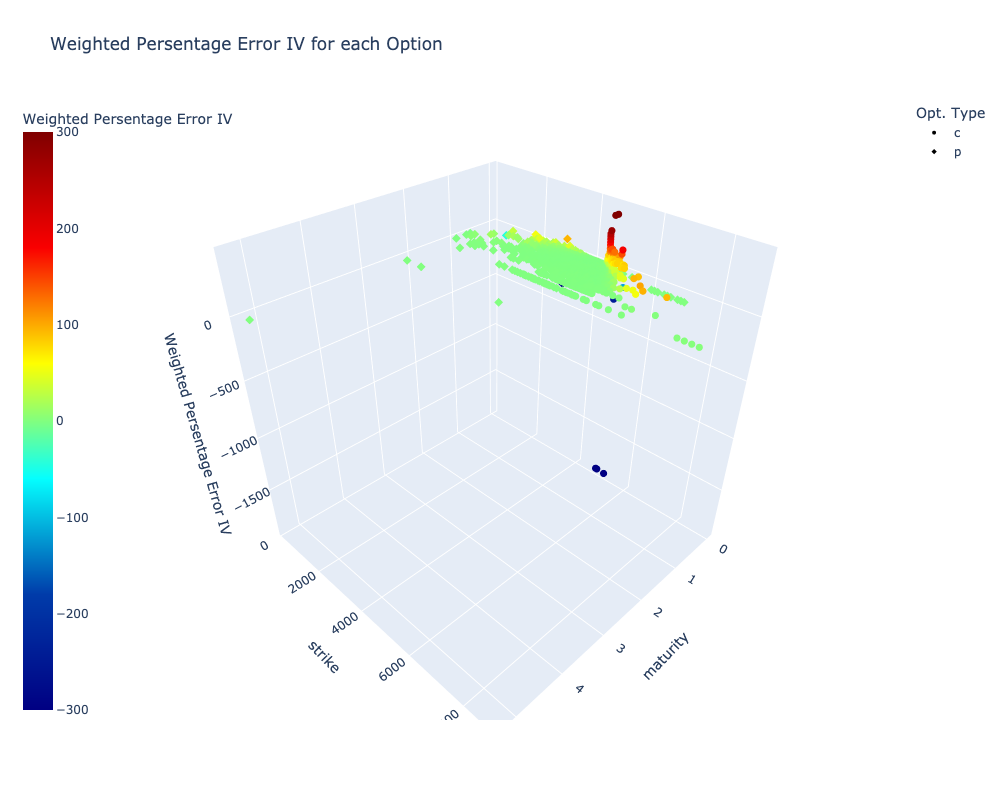

In [34]:
# error = 'Perc Error' or 'Error' or 'Squared Error'
results_df = get_error_df_Heston(volSurface, v0, kappa, theta, zeta, rho, diff='IV', error='Perc Error', weighted=1, N=1_024, z=24)
_name = results_df.columns[2]

fig = px.scatter_3d(results_df,
                    x='maturity',
                    y='strike',
                    z=_name,
                    width=1000,
                    height=800,
                    size_max=.5,
                    color=_name,
                    symbol='Opt. Type',
                    title=f'{_name} for each Option',
                    color_continuous_scale='jet',
                    range_color=[-300,300])
fig.update_layout(coloraxis_colorbar_x=-.10)
fig.update_traces(marker={'size': 4})
fig.show()
# results_df

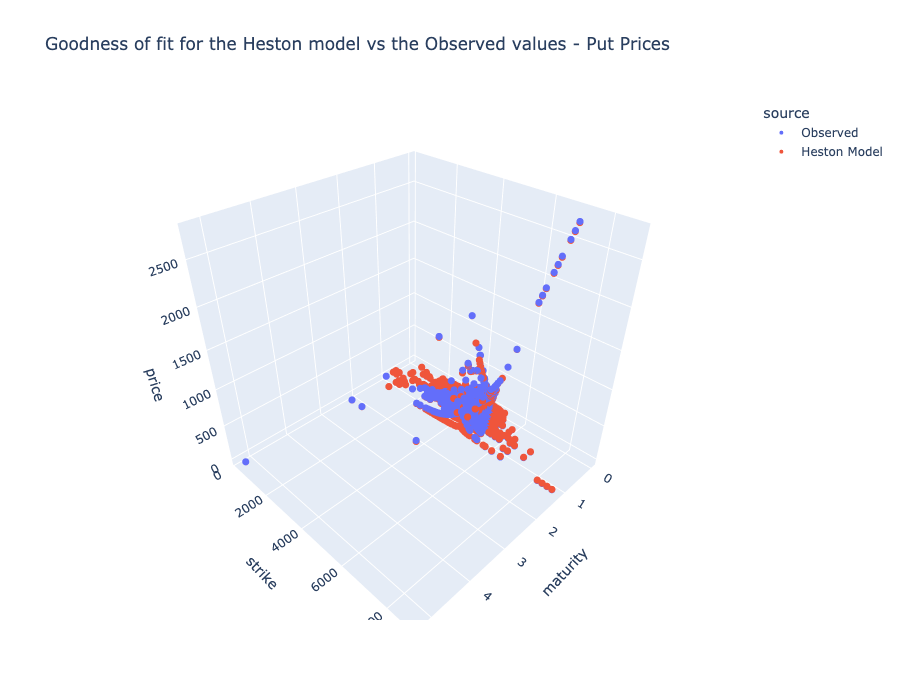

In [35]:
resulds_df = get_resutls_df_Heston(
    volSurface, v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, N=1_024, z=24
)

fig = px.scatter_3d(
    resulds_df,
    x="maturity",
    y="strike",
    z="price",
    color="source",
    width=900,
    height=700,
    title="Goodness of fit for the Heston model vs the Observed values - Put Prices",
    hover_data=[
        "strike",
        "price",
        "DaysSinceLastTraded",
        "maturity",
        "Type",
        "IV",
        "source",
    ],
)
fig.update_traces(marker={"size": 4})
fig.show()

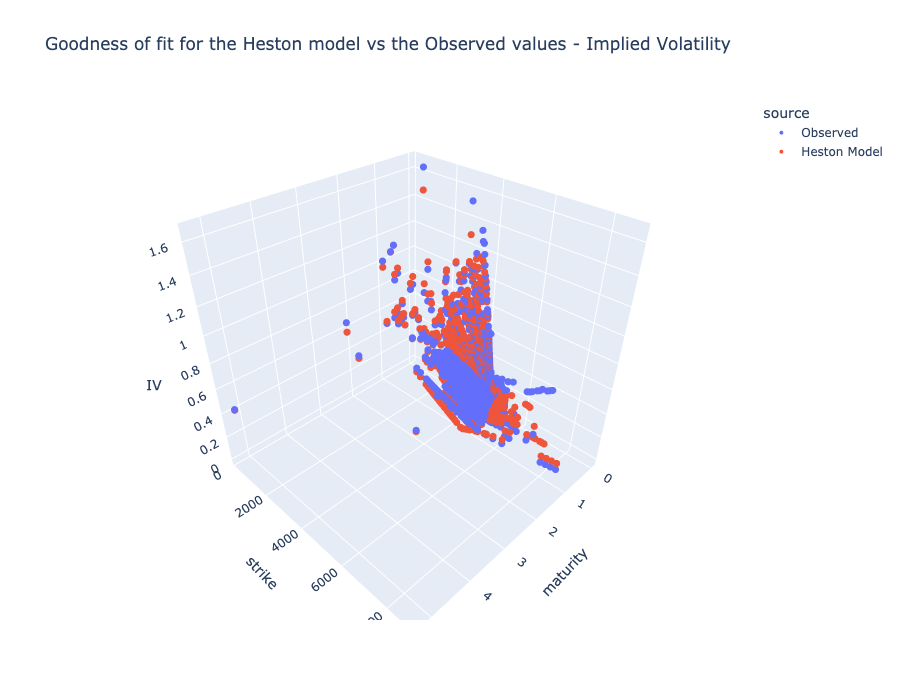

In [36]:
# Plot the results
fig = px.scatter_3d(
    resulds_df, 
    x='maturity', 
    y='strike', 
    z='IV', 
    color='source', 
    width=900, 
    height=700,
    title='Goodness of fit for the Heston model vs the Observed values - Implied Volatility', 
    hover_data=["strike", "price", "DaysSinceLastTraded", "maturity", "Type", "IV", "source"]
)
fig.update_traces(marker={'size': 4})
fig.show()
# resulds_df

### Implied Volatility sourface

K/S min = 0.04494059031703634, K/S max = 1.9773859739495987


Calculating Heston Implied Volatility Surface: 100%|██████████| 15000/15000 [00:22<00:00, 665.17it/s]


Errors: 3822 (25.48%)


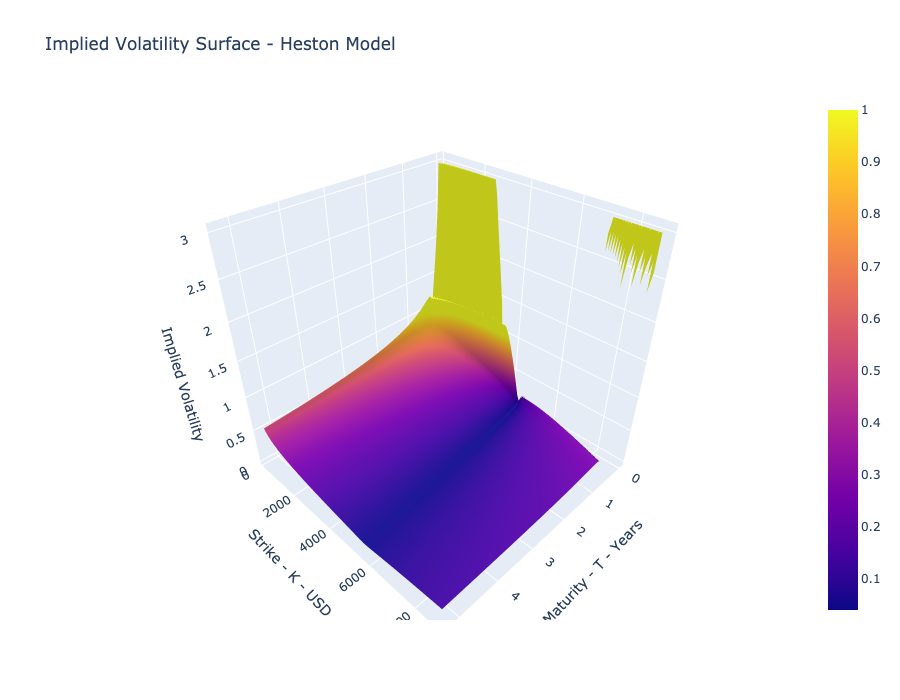

In [37]:
# Initialize variables
is_safe_mode = True
min_strike = results_df['strike'].min()
max_strike = results_df['strike'].max()
maturity_min_log = np.log10(results_df['maturity'].min())
maturity_max_log = np.log10(results_df['maturity'].max())
# maturity_max_log = np.log10(1)


# Generate x and y grid values
x_values = np.logspace(maturity_min_log, maturity_max_log, 150)
y_values = np.linspace(min_strike, max_strike, 100)
print(f'K/S min = {min_strike/S0}, K/S max = {max_strike/S0}')

# Generate meshgrid
X_grid, Y_grid = np.meshgrid(x_values, y_values)
flat_X = X_grid.flatten()
flat_Y = Y_grid.flatten()
implied_vols = []

# Initialize constants
S0_array = np.array(S0, ndmin=1)

# Calculate implied volatility
for T, K in tqdm(list(zip(flat_X, flat_Y)), desc='Calculating Heston Implied Volatility Surface'):
    r = curve_fit(T) / 100
    option_price = Fourier_Heston_Put(S0=S0, K=K, v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, T=T, r=r, N=10_012, opt_type='p', z=24)
    implied_vol = get_implied_volatility(price=option_price, S=S0_array, K=np.array(K, ndmin=1), t=np.array(T, ndmin=1), r=np.array(r, ndmin=1), flag=np.array('p', ndmin=1))[0]

    # Apply safety checks
    if is_safe_mode and implied_vol >= 3:
        implied_vol = 3
    implied_vols.append(implied_vol)

# Reshape and handle errors
reshaped_implied_vols = np.array(implied_vols).reshape(-1, x_values.shape[0])
invalid_indices = reshaped_implied_vols <= 0
if is_safe_mode:
    reshaped_implied_vols[invalid_indices] = np.nan
print(f"Errors: {invalid_indices.sum():.0f} ({invalid_indices.mean()*100:.2f}%)")

# Plotting
fig = go.Figure(data=[go.Surface(x=X_grid, y=Y_grid, z=reshaped_implied_vols, surfacecolor=np.where(reshaped_implied_vols < 1, reshaped_implied_vols, 1))])
fig.update_layout(
    scene=dict(
        xaxis_title='Maturity - T - Years',
        yaxis_title='Strike - K - USD',
        zaxis_title='Implied Volatility'
    ),
    title='Implied Volatility Surface - Heston Model',
    width=900,
    height=700
)
fig.update_coloraxes(colorscale='Picnic')
fig.show()


# End
----------------------------------------------------------------
# Old Implementations - Backup

In [38]:
end_of_notebook

NameError: name 'end_of_notebook' is not defined

## Implementation from the Stochastic Calculus course:
$$
\varphi(\omega)=\mathbb{E}^{\mathbb{Q}}\left[e^{i \omega \log \left(S_T\right)} \mid \mathcal{F}_t\right]=e^{i \omega m-\frac{1}{2} \omega^2 \sigma^2(T-t)},
$$
with $m=\log \left(S_t\right)+\left(r-\delta-\frac{1}{2} \sigma^2\right)(T-t)$, and for the Heston model
$$
\varphi(\omega)=\mathbb{E}^{\mathbb{Q}}\left[e^{i \omega \log \left(S_T\right)} \mid \mathcal{F}_t\right]=e^{i \omega m+\alpha+\beta v_0},
$$
with $m=\log \left(S_t\right)+(r-\delta)(T-t)$ and
$$
\begin{aligned}
\alpha & =\frac{\kappa \theta}{\zeta^2}\left[(\kappa-\rho \zeta i \omega-d)(T-t)-2 \log \frac{1-c e^{-d(T-t)}}{1-c}\right], & \beta & =\frac{(\kappa-\rho \zeta i \omega-d)\left(1-e^{-d(T-t)}\right)}{\zeta^2\left(1-c e^{-d(T-t)}\right)} \\
d & =\sqrt{(\rho \zeta i \omega-\kappa)^2+\zeta^2\left(i \omega+\omega^2\right)}, & c & =\frac{\kappa-\rho \zeta i \omega-d}{\kappa-\rho \zeta i \omega+d}
\end{aligned}
$$

## Heston Model - Characteristic Function
$$\begin{align*}
& \varphi(u) &=\;& \exp \left(\mathrm{i} u\left(\log S_0+(r-q) T \right)\right) \\
&&& \times \exp \left(\theta \kappa \zeta^{-2}\left((\kappa-\rho \zeta \mathrm{i} u-d) T - 2 \log \left(\left(1-g \mathrm{e}^{-d*T}\right) /\left(1-g\right)\right)\right)\right) \\
&&& \times \exp \left(\sigma_0^2 \zeta^{-2}(\kappa-\rho \zeta \mathrm{i} u-d)\left(1-\mathrm{e}^{-d*T}\right) /\left(1-g \mathrm{e}^{-d*T}\right)\right), \\
& g &=\;& (\kappa-\rho \zeta \mathrm{i} u-d) /(\kappa-\rho \zeta \mathrm{i} u+d) \\
& d &=\;& \sqrt{(\rho \zeta u \mathrm{i}-\kappa)^2+\zeta^2\left(\mathrm{i} u+u^2\right)}
\end{align*}$$


In [ ]:
def heston_char(u, kappa, theta, rho, zeta, v0): 
    t = 0.0
    q = 0.0
    m = log(S0) + (r - q)*(T-t)
    d = sqrt((rho*zeta*1j*u - kappa)**2 + zeta**2*(1j*u + u**2))
    c = (kappa - rho*zeta*1j*u - d) / (kappa - rho*zeta*1j*u + d)
    beta = ((kappa - rho*zeta*1j*u - d)*(1-exp(-d*(T-t)))) / (zeta**2*(1-c*exp(-d*(T-t))))
    alpha = ((kappa*theta)/(zeta**2))*((kappa - rho*zeta*1j*u - d)*(T-t) - 2*log((1-c*exp(-d*(T-t))/(1-c))))
    return exp(1j*u*m + alpha + beta*v0)

In [ ]:
@njit
def MC_Heston_Put(S0, K, T, r, 
                    # Heston Model Paramters
                    kappa, # Speed of the mean reversion 
                    theta, # Long term mean
                    rho,   # correlation between 2 random variables
                    zeta,  # Volatility of volatility
                    v0,    # Initial volatility 
                    opt_type,
                    M=10_000,
                    N=252,
                ):
    
    dt = T / N
    # np.random.seed(42)

    S = np.zeros((M, N+1))
    V = np.zeros((M, N+1))
    S[:, 0] = S0
    V[:, 0] = v0

    for t in range(1, N+1):
        Z1 = np.random.standard_normal(M)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.standard_normal(M)

        # Euler scheme for the asset price and volatility
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * V[:, t-1]) * dt + np.sqrt(V[:, t-1] * dt) * Z1)
        V[:, t] = np.maximum(0, V[:, t-1] + kappa * (theta - V[:, t-1]) * dt + zeta * np.sqrt(V[:, t-1] * dt) * Z2)

    if opt_type == "c": F = np.maximum(S[:, -1] - K, 0)
    if opt_type == "p": F = np.maximum(K - S[:, -1], 0)

    return F.mean() *  exp(-r*T) , (F.reshape(100,-1).sum(axis=1)/100).std() / sqrt(100.0)

In [ ]:

def get_S(DaysSinceLastTraded:np.array, SPX_Closing_prices:pd.Series):
    """Get the corresponding Clossing price of SPX for the day which the option traded
    Returns:
        np.array: SPX prices
    """
    S = np.zeros_like(DaysSinceLastTraded, dtype=np.float32)
    for idx, td in enumerate(DaysSinceLastTraded):
        S[idx] = SPX_Closing_prices[td]
    return S

SPX = yf.Ticker("^SPX")

# Step 1: get Clossing Prices
SPX_Prices = (SPX.history(perdiod='3mo')['High'] + SPX.history(perdiod='3mo')['Low'])/2
# SPX_Prices = SPX.history(perdiod='3mo')['Close']
# SPX_Prices = SPX.history(perdiod='3mo')['Open']

# Step 2: get Expiration Dates
expiration_dates = SPX.options

# Step 3: get option chain for each expiration date
df = []
for expiration_date in tqdm(expiration_dates):
    # Collect all Calls
    _df = SPX.option_chain(expiration_date).calls
    _df['DaysSinceLastTraded'] = (pd.to_datetime(_df['lastTradeDate']).dt.tz_localize(None) - pd.to_datetime(datetime.now())).dt.days
    _df = _df[_df['DaysSinceLastTraded'] > -14]
    _df = _df[['strike', 'lastPrice', 'DaysSinceLastTraded']]
    _df = _df.rename(columns={'lastPrice': 'price'})
    _df['maturity'] = (pd.to_datetime(expiration_date) - pd.to_datetime(datetime.now())).days / 365
    _df['Type']     = 'c'
    _df['S']        = get_S(_df['DaysSinceLastTraded'].values, SPX_Prices)
    df.append(_df)

    # Collect all Puts
    _df = SPX.option_chain(expiration_date).puts
    _df['DaysSinceLastTraded'] = (pd.to_datetime(_df['lastTradeDate']).dt.tz_localize(None) - pd.to_datetime(datetime.now())).dt.days
    _df = _df[_df['DaysSinceLastTraded'] > -7]
    _df = _df[['strike', 'lastPrice', 'DaysSinceLastTraded']]
    _df = _df.rename(columns={'lastPrice': 'price'})
    _df['maturity'] = (pd.to_datetime(expiration_date) - pd.to_datetime(datetime.now())).days / 365
    _df['Type']     = 'p'
    _df['S']        = get_S(_df['DaysSinceLastTraded'].values, SPX_Prices)
    df.append(_df)

df = pd.concat(df)
df = df[df['maturity'] > 0]

# Days since Last Traded. If yesterday's results are uploaded to yfinance. Then the max should be -1.
# -> change iloc -1 to -2 depending on how many days you want to take
Lookback_limit = df['DaysSinceLastTraded'].sort_values().unique()[-2]

# Plot Density of Options for each maturity
DaysSinceLastTraded_df = df.groupby(['DaysSinceLastTraded', 'maturity'])['price'].count().reset_index()
DaysSinceLastTraded_df['Included/Exculded'] = ['Included' if x >= Lookback_limit else 'Excluded' for x in DaysSinceLastTraded_df['DaysSinceLastTraded'].values]
DaysSinceLastTraded_df['Number of Options']  = DaysSinceLastTraded_df['price'].values

fig = px.scatter(DaysSinceLastTraded_df, x='maturity', y='DaysSinceLastTraded', color='Included/Exculded', size='Number of Options',
    width=1100, height=500, title='Density of : Days Since Last Traded')
fig.show()

# Limit the space to calibrate the model according to requirements
volSurfaceLong = (
    df
    [ (df['maturity'] > 1/365)
    & (df['DaysSinceLastTraded'] >= Lookback_limit)
    ] # Taking only options which were traded at most 2 weeks ago
    # [(df['strike'] > 3000) & (df['strike'] < 4800) &  df['maturity'] > 0] # & (df['maturity'] < 1)
)
del _df, df, DaysSinceLastTraded_df

volSurfaceLong['rate'] = volSurfaceLong['maturity'].apply(curve_fit) / 100
volSurfaceLong         = volSurfaceLong.reset_index()
volSurfaceLong.describe()

In [ ]:
volSurface = volSurfaceLong.copy(deep=True)
volSurface['Weight'] = np.nan

print(f'Distribution of Puts Over Time. Total number of Options offered: {volSurface.shape[0]}')
for t0 in range(0, int(np.ceil(volSurfaceLong['maturity'].max())) ):
    print(f'T: ({t0}, {t0+1}], Number of Options offered = ', volSurfaceLong[ (volSurfaceLong['maturity']>t0) & (volSurfaceLong['maturity']<=(t0+1)) ].shape[0])
    n_options = volSurface[ (volSurface['maturity']>t0) & (volSurface['maturity']<=(t0+1)) ].shape[0]
    volSurface.loc[ (volSurface['maturity']>t0) & (volSurface['maturity']<=(t0+1)), 'Weight'] = 1/n_options if n_options >0 else 0

volSurface['Weight'] = volSurface['Weight'] / volSurface['Weight'].min()# volSurface.describe(include='all')
volSurface.groupby('maturity')['Weight'].mean().plot(title='Weighting of Options over Time', ylabel='Weight', xlabel='Maturity - Years', marker='.', legend=1) ; plt.show()

In [ ]:
from scipy.optimize import dual_annealing

_K      = volSurface['strike'].to_numpy()
_C      = volSurface['price'].to_numpy()
_type   = volSurface['Type'].to_numpy(dtype=str)
_T      = volSurface['maturity'].to_numpy()
_r      = volSurface['rate'].to_numpy()
_S      = np.full_like(_K, S0)
_IV     = volSurface['IV'].to_numpy()
_Weight = volSurface['Weight'].to_numpy()

# Parameters to search for in the simualation: --------------------------------
# v0=0.3001, kappa=5.4637, theta=0.5989, zeta=3.9459, rho=-0.0000
#0.6 2.3269448229137257 0.13823165264953244 1.9580119277387602 -0.5677217358052269
params = {"v0":     {"x0": 0.3,             "lbub": [1e-3,  1.2]}, 
          "kappa":  {"x0": 0.3269448,       "lbub": [1e-3,  10]},  
          "theta":  {"x0": 0.1382316,       "lbub": [1e-3,  0.6]}, 
          "zeta":   {"x0": 1.9580,          "lbub": [1e-2,  4]},
          "rho":    {"x0": -0.5677,         "lbub": [-1,    1]},
          }
x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]

def SqErr(x):
    v0, kappa, theta, zeta, rho = [param for param in x]
    
    # Prices Using Heston Model
    Price_Heston    = get_resutls_array_Heston(volSurface, v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, N=1048)

    # Inverse approximation of implied Volatilities
    IV_Heston       = implied_volatility(price=Price_Heston, S=_S, K=_K, t=_T, r=_r, flag=_type)
    
    # Safty Feature: Exclude the IV caluclations which are not definable.
    diff            = IV_Heston - _IV
    idx             = np.isnan(diff) | np.isinf(diff)
    diff[idx]       = - _IV[idx]

    IV_Heston[idx]  = 0
    
    ## W_RMSE
    wrmse = sqrt(np.mean((diff*100)**2 * _Weight))

    zeros = np.where(IV_Heston==0, 1,0).mean() * 100
    wmae   = np.mean(np.abs(diff*100) * _Weight)

    print(f">>v0={v0:7.4}; kappa={kappa:5.4f}; theta={theta:5.4f}; zeta={zeta:5.4f}; rho={rho:6.4f} | WMAE_IV: {wmae:5e} | Nulls: {(idx).sum()}/{idx.shape[0]} | Zeros: {zeros:.2f}% | WRMSE: {wrmse:5e}")
    return wrmse

# visit -> float, optional
# Parameter for visiting distribution. Default value is 2.62. Higher values give the visiting distribution a heavier tail,
# this makes the algorithm jump to a more distant region. The value range is (1, 3].
#
# initial_temp -> float, optional
# The initial temperature, use higher values to facilitates a wider search of the energy landscape, allowing dual_annealing to escape local minima that it is trapped in. 
# Default value is 5230. Range is (0.01, 5.e4].
###
# Perform scipy minimize to find the best parameters in the Heston Model which match the observed values
result = dual_annealing(SqErr, x0=x0, bounds=bnds, maxiter=10, maxfun=200, no_local_search=True, visit=1.01, accept=-.02, initial_temp=1)
v0, kappa, theta, zeta, rho = [param for param in result.x]


In [ ]:
def get_error(x, show=False, ):
    left = x[0] ; scale = x[1] ; base = x[2] ; L = x[3]

    S0      = 100.      # initial asset price
    v0 = 0.4173 ; kappa = 0.4352 ; theta = 0.2982 ; zeta = 1.3856 ; rho = -0.0304

    Ks = np.arange(10,400,10)
    Ts = [1/365,2/365,3/365,4/365,5/365, 2/52, 3/52,4/52,2/12,3/12,4/12,6/12,1,2,3,5,7,10,20,30]
    results = {'T':[], 'K':[], 'IV_F':[], 'IV_M':[]}
    for T in tqdm(Ts, leave=False):
        for K in Ks:
            _r = curve_fit(T) / 100
            results['T'].append(T)
            results['K'].append(K)
            price = Fourier_Heston_Put(S0=S0, K=K, v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, T=T, r=_r, N=512, opt_type='p', left = left, scale = scale, base = base, L=L)
            price_, S0_, K_, T_, _r_, flag = np.array(price, ndmin=1), np.array(S0, ndmin=1), np.array(K, ndmin=1), np.array(T, ndmin=1), np.array(_r, ndmin=1), np.array('p', ndmin=1)
            results['IV_F'].append( implied_volatility(price_, S0_, K_, T_, _r_, flag)[0] )
            # price = float(MC_Heston_Put(S0=S0, K=K, v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, T=T, r=_r, opt_type='p', N=3_000)[0])
            # price_, S0_, K_, T_, _r_, flag = np.array(price, ndmin=1), np.array(S0, ndmin=1), np.array(K, ndmin=1), np.array(T, ndmin=1), np.array(_r, ndmin=1), np.array('p', ndmin=1)
            # results['IV_M'].append( implied_volatility(price_, S0_, K_, T_, _r_, flag) )
    results['IV_M'] = np.array([0., 0., 0., 0., 0.,
       0., 0., 0., 0.70487605,
       0.63975695, 0.94478135, 0., 0.,
       0., 0., 2.54052813, 0.,
       0., 4.32823602, 5.11213025,
       5.19001277, 0., 0., 4.7786666,
       0., 0., 0., 5.74578612,
       0., 6.82234288, 0., 0.,
       0., 8.45108716, 0., 8.03086084,
       8.65294081, 0., 8.87708714, 0.,
       0., 0., 0., 0., 0.,
       0., 0., 0.65043475, 0.64670065,
       0.68944097, 0., 1.53039669,
       1.910203, 0., 2.73041696,
       2.65016554, 2.96589384, 3.54327497,
       3.04638011, 3.88411423, 0.,
       4.26645656, 4.11402167, 3.85622168,
       0., 0., 5.47866096, 5.41241982,
       0., 0., 5.83199375, 5.80366305,
       5.70464034, 5.66534586, 6.18072889,
       6.14262122, 0., 0., 0.,
       0., 0., 0., 0., 0.,
       0., 0., 0.64545657, 0.63720055,
       0.67849813, 0.73966712, 1.31306642,
       0., 0., 2.00316841, 2.23132153,
       2.23710284, 0., 0., 0.,
       0., 0., 3.64031292, 3.90844892,
       0., 3.81145572, 4.12424567,
       3.93547224, 3.47512182, 0.,
       5.02534749, 4.05670514, 4.87237775,
       0., 0., 0., 5.45109989,
       5.2850413, 0., 0., 0.,
       0., 0., 0., 0.,
       0.71011315, 0.64431737, 0.65113898,
       0.66006557, 0.75286626, 0., 0.,
       1.37585385, 1.85024809, 2.12115246,
       0., 2.19066337, 0., 2.51859618,
       0., 0., 3.18580478, 0.,
       3.17733184, 3.65648049, 0., 0.,
       3.79395365, 4.13832884, 0.,
       4.32645677, 3.85925826, 4.25035196,
       0., 4.37218459, 4.83302309, 0.,
       0., 0., 0., 0., 0.,
       0., 0., 0.63625903, 0.64850918,
       0.65928979, 0.64880853, 0.66968015,
       0., 0., 0., 0., 0.,
       0., 2.38516051, 1.91232914,
       2.55065893, 2.42023469, 2.78117231,
       0., 3.10274451, 0., 0.,
       3.62181673, 3.2675764, 0., 0.,
       0., 3.68447713, 3.44167463, 0.,
       0., 3.78430256, 0., 4.23672571,
       0., 0., 0., 0., 0.,
       0., 0.69333405, 0.65156153,
       0.6319354, 0.63233601, 0.66347144,
       0.6228576, 0.64966846, 0.,
       0.85872755, 0., 1.17275973, 0.,
       0., 1.38183552, 0., 1.45349963,
       0., 1.61023827, 0., 2.06391351,
       0., 2.00812614, 1.87146184,
       2.319463, 1.86739642, 2.44953579,
       0., 0., 2.64973434, 2.48221243,
       2.69374826, 2.23879386, 2.70112874,
       0., 0., 0., 0.,
       0.73892666, 0.65433858, 0.69565146,
       0.65473339, 0.65114932, 0.63235397,
       0.62601381, 0.63389969, 0.65944759,
       0.69386963, 0.68951328, 0.6600043,
       0., 0.81672721, 0., 1.13718566,
       0., 0., 0., 0.,
       1.43537179, 1.73737665, 1.42127108,
       0., 1.62821284, 0., 0.,
       1.8255709, 1.90645761, 1.83117256,
       0., 0., 1.61991409, 0.,
       2.38424883, 0., 0., 0.,
       0.70637439, 0.73675652, 0.71088179,
       0.67739297, 0.65033431, 0.63517726,
       0.65157209, 0.64434527, 0.65532764,
       0.62940084, 0.70587503, 0.51473535,
       0.75155954, 0.73770513, 0.88891411,
       0.96708514, 1.15282049, 0.97639127,
       1.15921512, 1.16909564, 0.90019814,
       0., 1.30574067, 0., 1.42003867,
       1.49981364, 1.38161433, 0., 0.,
       1.64653036, 1.53449509, 0., 0.,
       0., 0., 0., 0., 0.,
       0., 0.73551067, 0.71720099,
       0.69436846, 0.67975087, 0.63945387,
       0.63709391, 0.61105319, 0.63073363,
       0.62374347, 0.64748978, 0.62436666,
       0.65516823, 0.67739131, 0.73243342,
       0.63105054, 0.68788193, 0., 0.,
       0.90327053, 0.94759871, 0.,
       0.93406983, 0., 1.05461965, 0.,
       0., 0., 1.02506665, 0.,
       1.22820034, 1.14917542, 0., 0.,
       1.29262365, 0.90667488, 1.22234798,
       1.13485689, 0.85542839, 0.81233221,
       0.74057408, 0.73056103, 0.67622705,
       0.65096786, 0.63922112, 0.6269564,
       0.61542037, 0.62859844, 0.62246659,
       0.61568572, 0.62359574, 0.65492124,
       0.70378183, 0.63901291, 0.63181139,
       0.67815271, 0.73488329, 0.78044811,
       0.73745684, 0.49338992, 0.77585304,
       0.7668736, 0.94316381, 0.88184439,
       0.91375973, 0.87073869, 0.96445975,
       0., 0., 0.88838974, 0.9763282,
       0.92429615, 0., 0., 0.,
       0., 0., 0.86815908, 0.82031871,
       0.74198874, 0.69996454, 0.68099219,
       0.64403548, 0.61554536, 0.59798513,
       0.6024333, 0.6069522, 0.60979643,
       0.62706722, 0.64246639, 0.65276864,
       0.63214533, 0.69346735, 0.72155379,
       0.70775621, 0.72757354, 0.72274012,
       0., 0.74590226, 0., 0.,
       0.8800204, 0.8035334, 0.70820517,
       0.80822941, 0.89609414, 0.73294483,
       0.95128929, 1.02675772, 0.,
       0.96542364, 1.05005228, 0., 0.,
       0., 0.99342475, 0.85174826,
       0.78158017, 0.74483296, 0.69684445,
       0.66167834, 0.63834207, 0.61254664,
       0.59946274, 0.59133788, 0.58806545,
       0.59685962, 0.59724867, 0.607735,
       0.62092839, 0.62759581, 0.66135351,
       0.67163257, 0.6712268, 0.68140909,
       0.71007003, 0.70160017, 0.64193441,
       0.71884308, 0.79459043, 0.64844066,
       0.72351768, 0.71829799, 0.71257313,
       0.69467145, 0.68488887, 0.77982238,
       0.74208923, 0.87132417, 0.72218216,
       0.80703897, 0.66663426, 0., 0.,
       0.91223201, 0.80019145, 0.73463001,
       0.70295635, 0.6577464, 0.62954742,
       0.60523248, 0.56440916, 0.55143308,
       0.55117046, 0.55632438, 0.55533905,
       0.57400877, 0.57478863, 0.57286106,
       0.56022647, 0.59907543, 0.58485224,
       0.63415476, 0.62189094, 0.6168616,
       0.65150381, 0.60670699, 0.68103387,
       0.67166006, 0.67416545, 0.62958523,
       0.67160708, 0.70319346, 0.66004418,
       0.70814344, 0.67273184, 0.71307325,
       0.7247512, 0.72258692, 0.67633645,
       0.742633, 0.75686067, 0.7221795,
       0.83758617, 0.7303344, 0.67523382,
       0.6321816, 0.60456659, 0.57238657,
       0.54799927, 0.53732742, 0.52181797,
       0.50688246, 0.52844161, 0.51077111,
       0.51140474, 0.52566888, 0.52697595,
       0.5191377, 0.5391277, 0.54712286,
       0.55476089, 0.55477853, 0.56150426,
       0.57373668, 0.57662624, 0.60213949,
       0.58686624, 0.57260392, 0.60688432,
       0.62400663, 0.59985795, 0.64383765,
       0.61669743, 0.610302, 0.59836685,
       0.63574981, 0.63327449, 0.64282109,
       0.6646185, 0.63696943, 0.68247915,
       0.77389077, 0.68255255, 0.62387633,
       0.59006042, 0.5615066, 0.53866654,
       0.5261022, 0.50768755, 0.50463102,
       0.51085989, 0.50457817, 0.50062085,
       0.49148025, 0.5104839, 0.50558932,
       0.51724984, 0.5070651, 0.51557664,
       0.52565813, 0.52992654, 0.53204414,
       0.53749281, 0.53849102, 0.55332237,
       0.56409925, 0.56084011, 0.5599182,
       0.56552154, 0.56917916, 0.57437756,
       0.56135063, 0.57995906, 0.58552375,
       0.5954708, 0.60042247, 0.60620598,
       0.59313737, 0.57433364, 0.60387796,
       0.68374697, 0.62113388, 0.57932826,
       0.55353523, 0.54342232, 0.51678546,
       0.51626868, 0.51351577, 0.50275332,
       0.48771878, 0.49764322, 0.50550734,
       0.48873367, 0.48961577, 0.49571372,
       0.49610612, 0.5003236, 0.4976827,
       0.5029091, 0.51343711, 0.51728879,
       0.51019123, 0.51783233, 0.51252907,
       0.51337511, 0.52302663, 0.52316747,
       0.52478813, 0.5255556, 0.52088454,
       0.53315657, 0.53172724, 0.54289971,
       0.5391167, 0.53767513, 0.54628078,
       0.54676653, 0.54817302, 0.55800717,
       0.62855253, 0.58240402, 0.56016283,
       0.53907435, 0.52526592, 0.51754469,
       0.51815328, 0.50461821, 0.49639309,
       0.49521075, 0.49330124, 0.49325285,
       0.49426416, 0.49816923, 0.49830894,
       0.49461217, 0.49600223, 0.49239642,
       0.49860411, 0.50410327, 0.5013852,
       0.5088872, 0.5027066, 0.49431856,
       0.50242459, 0.51460798, 0.50933264,
       0.51371588, 0.51296198, 0.51190918,
       0.51757215, 0.51260395, 0.51079476,
       0.52055571, 0.52157219, 0.52614249,
       0.51141315, 0.53246519, 0.52382875,
       0.60054608, 0.55853726, 0.54452027,
       0.53342446, 0.52603284, 0.51219632,
       0.51416993, 0.50988302, 0.50449592,
       0.49928431, 0.49986153, 0.49918345,
       0.4983549, 0.50053982, 0.49539749,
       0.49493806, 0.49434969, 0.50365318,
       0.50033867, 0.50495291, 0.49834984,
       0.50439756, 0.4888819, 0.50675508,
       0.49243162, 0.51788138, 0.50241324,
       0.49816408, 0.49916487, 0.49960329,
       0.51200584, 0.51050869, 0.51324015,
       0.50629886, 0.51473643, 0.52457009,
       0.50825658, 0.50607601, 0.51604032,
       0.56911209, 0.55242489, 0.54343681,
       0.53913469, 0.52554902, 0.52928747,
       0.52370371, 0.53102801, 0.52348272,
       0.51758003, 0.52045803, 0.51714774,
       0.52149138, 0.52161307, 0.52117144,
       0.51863725, 0.51896873, 0.51876809,
       0.51554934, 0.51713864, 0.50995862,
       0.51931802, 0.51334403, 0.51475937,
       0.51154589, 0.52434177, 0.52090059,
       0.52454606, 0.52246993, 0.52146878,
       0.51574532, 0.51067046, 0.51925177,
       0.51846819, 0.51573999, 0.51710862,
       0.51414186, 0.51296432, 0.51314893,
       0.55752384, 0.55279516, 0.54515253,
       0.54219689, 0.53418594, 0.53635134,
       0.53377506, 0.53367739, 0.53601551,
       0.53473718, 0.5320828, 0.531209,
       0.53350032, 0.53039728, 0.53099234,
       0.52786144, 0.53196027, 0.53131598,
       0.53084753, 0.53001054, 0.53060376,
       0.52980657, 0.52104101, 0.52503408,
       0.5313749, 0.53343025, 0.52837505,
       0.52795918, 0.52906715, 0.52511708,
       0.53808964, 0.53195957, 0.53052444,
       0.53434541, 0.52716601, 0.52150717,
       0.52188087, 0.52378997, 0.52937364])
    # return results
    results = pd.DataFrame.from_dict(results)
    # return results['IV_M'].values
    results['Error'] = results['IV_F'] - results['IV_M']
    results['Perc Error'] = results['Error'] / results['IV_M'] * 100
    mse = ((results.loc[:,'IV_F'] - results.loc[:,'IV_M'])**2).mean()
    if show:
        print(f"""
        Mean Error = {(results.loc[:,'IV_F'] - results.loc[:,'IV_M']).abs().mean()}
        Perc Error = {results.loc[results['Perc Error'] != np.inf, 'Perc Error'].abs().mean()}
        mse = {mse:5.5}
        """)
        fig = px.scatter(results, x="K", y="T", color='Error', color_continuous_scale='jet', hover_data=['K','T','Error','IV_F', 'IV_M', 'Perc Error'], log_y=1)#, range_color=[-100,100]) 
        fig.show()
    else: print(f'left = {left:5.3}; scale = {scale:5.3}; base ={base:5.3}; L ={L:5.3} | mse = {mse:5.5}')
    return mse

x = -2.4993388333988213, 3.9242601057566233, 19.999999985177766, 47.21335716127004
get_error(x, show=True)

In [ ]:
x = np.logspace(log(1/365), log(5), 365*5*10, base=np.e)

left = 0
scale = 1.9242601057566233,
base = 1.999999985177766,
L = 100,
# y  = 500 / (1 + base**(aa*(x-bb))) + 28`
f = lambda x: base**(1/(scale*x+left)) + 100
f = lambda T: L + (300/(1+base**(scale*(T-left)))) 
y = f(x)
# print(f'f(1/350)={f(1/365)}')
fig = px.line(x=x, y=y)
fig.show()

In [ ]:
params = {
        "left":     {"x0": .7,           "lbub": [-3,  3]}, 
        "scale":  {"x0": 1,              "lbub": [1e-5,  10]},  
        "base":  {"x0": 2.72,               "lbub": [1e-1,  20]}, 
        "L":    {"x0": 100,               "lbub": [5,  1000]}, 
        }
x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]

result = minimize(get_error, x0, tol = 1e-7, method='SLSQP', options={'maxiter': 1000 , 'ftol': 1e-7, 'disp':True}, bounds=bnds, jac='3-point')
print([param for param in result.x])